In [1]:
import os
import pandas as pd
import numpy as np
from IPython.display import display
from matplotlib import pyplot as plt

from liquidity.response_functions.functional_form import rescaled_form, scaling_form
from liquidity.util.utils import bin_data_into_quantiles, smooth_outliers
from liquidity.response_functions.features import compute_aggregate_features
from liquidity.response_functions.fit import find_shape_parameters, compute_scale_factors, renormalise
from liquidity.response_functions.price_response_functions import compute_conditional_aggregate_impact

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
BIN_SIZE = list(range(1, 1001))
OBSERVATION_WINDOWS = [10, 20, 50, 100, 150]

## Load data

In [4]:
# TSLA Example
current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')
filename = "TSLA-2017-NEW.csv"
stock_file_path = os.path.join(data_dir, filename)
tsla_orderbook_states = pd.read_csv(stock_file_path)

In [5]:
display(tsla_orderbook_states)

,Unnamed: 0,event_timestamp,sign,side,lob_action,order_executed,execution_price,size,ask,bid,...,bid_queue_size_mean,midprice_change,R1,spread,date,daily_R1,daily_vol,daily_num,norm_size,signed_volume
0,0,2017-01-03 10:30:19.351489154,1,ASK,UPDATE,True,219.37,1,219.37,219.28,...,135.963741,0.000,0.000,0.09,2017-01-03,0.021159,277786,3279,0.008043,1
1,1,2017-01-03 10:30:19.351537884,1,ASK,REMOVE,True,219.37,15,219.37,219.28,...,135.963741,0.005,0.005,0.09,2017-01-03,0.021159,277786,3279,0.120647,15
2,2,2017-01-03 10:30:19.351549791,1,ASK,UPDATE,True,219.38,80,219.38,219.28,...,135.963741,0.005,0.005,0.10,2017-01-03,0.021159,277786,3279,0.643452,80
3,3,2017-01-03 10:30:19.351601187,1,ASK,UPDATE,True,219.38,80,219.38,219.29,...,135.963741,0.000,0.000,0.09,2017-01-03,0.021159,277786,3279,0.643452,80
4,4,2017-01-03 10:30:19.351702603,1,ASK,REMOVE,True,219.38,40,219.38,219.29,...,135.963741,0.050,0.050,0.09,2017-01-03,0.021159,277786,3279,0.321726,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1411991,3572,2017-12-29 14:59:11.533706465,1,ASK,REMOVE,True,311.06,321,311.06,311.02,...,151.020334,0.025,0.025,0.04,2017-12-29,0.019713,322243,3577,2.112474,321
1411992,3573,2017-12-29 14:59:50.386983509,-1,BID,REMOVE,True,311.03,200,311.10,311.03,...,151.020334,-0.030,0.030,0.07,2017-12-29,0.019713,322243,3577,1.324325,-200
1411993,3574,2017-12-29 14:59:50.387892067,-1,BID,UPDATE,True,311.02,200,311.05,311.02,...,151.020334,0.000,-0.000,0.03,2017-12-29,0.019713,322243,3577,1.324325,-200
1411994,3575,2017-12-29 14:59:50.387904347,-1,BID,UPDATE,True,311.02,2,311.05,311.02,...,151.020334,0.000,-0.000,0.03,2017-12-29,0.019713,322243,3577,0.013243,-2


## Finite-size scaling of conditional distrubutions (functions or curves)

#### Fitting functions

   Scaling function: $\mathscr{F}(x) = \frac{x}{(1 + |x|^\alpha)^{\frac{\beta}{\alpha}}}$
   Scaling form:  $R(ΔV,T) \approx R(1)T^\chi \times  \mathscr{F}\left(\frac{ΔV}{V_{D}T^\varkappa}\right)$
   Rescaled form: $R(ΔV) \approx R_T \times  \mathscr{F}\left(\frac{ΔV}{\mathcal{E}_T}\right)$


   In order to determine the rescaling exponents $\chi$ and $\varkappa$:

   1. The shape of $R(ΔV,T)$ is fitted for all T using the scaling form with scaling function given by $\mathscr{F}(x)$.

   2. Once shape parameters $\alpha$ and $\beta$ are fixed, we can map out scale factors $QN$ and $RN$, by fitting the
    rescaled_form on each $T$ whilst keeping constant the value of $\alpha$ and $\beta$ for all $T$.

## Part $I$: Determine shape parameters in scaling function $\mathscr{F}(x)$

In [6]:
# Compute aggregate features
aggregate_features = compute_aggregate_features(tsla_orderbook_states, BIN_SIZE)
display(aggregate_features)

,event_timestamp,midprice,sign,signed_volume,vol_imbalance,sign_imbalance,daily_R1,daily_vol,daily_num,T
0,2017-01-03 10:30:19.351489154,219.325,1,1,1,1,0.021159,277786,3279,1
1,2017-01-03 10:30:19.351537884,219.325,1,15,15,1,0.021159,277786,3279,1
2,2017-01-03 10:30:19.351549791,219.330,1,80,80,1,0.021159,277786,3279,1
3,2017-01-03 10:30:19.351601187,219.335,1,80,80,1,0.021159,277786,3279,1
4,2017-01-03 10:30:19.351702603,219.335,1,40,40,1,0.021159,277786,3279,1
...,...,...,...,...,...,...,...,...,...,...
1407,2017-12-28 13:16:43.223807877,313.815,1,7,25466,240,0.018781,393606,4526,1000
1408,2017-12-28 14:27:24.122486121,315.095,-1,-2,-12571,-194,0.018781,393606,4526,1000
1409,2017-12-29 11:02:24.311161836,311.975,1,2,-1334,-100,0.019713,322243,3577,1000
1410,2017-12-29 11:59:26.326567979,312.370,-1,-100,-2116,-84,0.019713,322243,3577,1000


In [7]:
# Compute aggregate impact
conditional_aggregate_impact = compute_conditional_aggregate_impact(aggregate_features)

# Remove Outliers
smoothed_aggregate_impact = smooth_outliers(conditional_aggregate_impact.copy())
display(smoothed_aggregate_impact)

,vol_imbalance,T,R
0,0.000004,1,0.000000
1,0.000054,1,0.236307
2,0.000288,1,0.236307
3,0.000288,1,0.000000
4,0.000144,1,2.363073
...,...,...,...
1407,0.024216,1000,68.152226
1408,-0.024216,1000,-166.121052
1409,-0.004140,1000,20.037084
1410,-0.006566,1000,-7.609019


 ### 1.2. Fix shape parameters $\alpha$ and $\beta$ by fitting scaling_form on entire aggregate impact series

In [8]:
popt, pcov, fit_func = find_shape_parameters(smoothed_aggregate_impact)

In [9]:
CHI, KAPPA, ALPHA, BETA, GAMMA = popt
print(f'chi: {CHI}')
print(f'kappa: {KAPPA}')
print(f'alpha: {ALPHA}')
print(f'beta: {BETA}')

chi: 0.7215233401598284
kappa: 0.9955407254075659
alpha: 0.5203337403062257
beta: 74.73224389826562


   – Once the found shape parameters $\alpha$ and $\beta$ of $\mathscr{F}(x)$ are fixed, we use them to map out scale factors $R_T$ and $\mathcal{E}_T$ by
   fitting the rescaled form $R(ΔV)$  as a funtion of $T$, which are accurately described by a power law $R_T \sim T^\chi$ and $\mathcal{E}_T \sim T^\varkappa$.

   – Use the mapped out scale factors $R_T$ and $\mathcal{E}_T$ to extract the rescaling exponents $\chi$ and $\varkappa$ and use them to perform a renomalization
   of the data and functions (curves) to obtain the final master curves.

### 2.1. Once $\alpha$ and $\beta$ are fixed, use them map out the series QN and RN as a functon of T.

In [10]:
# Compute scale factors using found shape parameters
RN_df, QN_df, RN_fit_object, QN_fit_object, fit_results_per_lag = compute_scale_factors(conditional_aggregate_impact, ALPHA, BETA)

/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/functional_form.py:31: RuntimeWarning: overflow encountered in power
  return x / np.power(1 + np.power(abs(x), alpha), beta / alpha)
/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/functional_form.py:112: RuntimeWarning: divide by zero encountered in divide
  return RN * scaling_function(imbalance / QN, alpha, beta)
/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/functional_form.py:31: RuntimeWarning: invalid value encountered in divide
  return x / np.power(1 + np.power(abs(x), alpha), beta / alpha)
/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/functional_form.py:112: RuntimeWarning: divide by zero encountered in divide
  return RN * scaling_function(imbalance / QN, alpha, beta)
/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/functional_form.p

[]

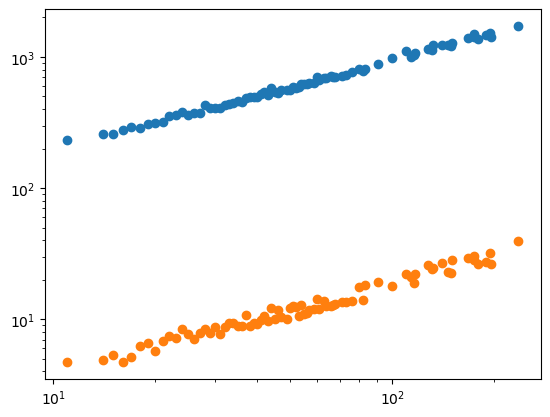

In [11]:
# Plot scale factors RN and QN
plt.scatter(RN_df['x_values'],RN_df['y_values'])
plt.scatter(QN_df['x_values'],QN_df['y_values'])
plt.loglog()

### 2.2. Determine rescaling exponents $\chi$ and $\varkappa$

In [12]:
chi = RN_fit_object.powerlaw.params.alpha
kappa = QN_fit_object.powerlaw.params.alpha
print(chi)
print(kappa)

0.6986979488533409
0.7313810198117843



For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 10
xmin: 23.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 38.03580050277998
alpha = 0.6986979488533409

Goodness of fit to data;
D = 0.043478260869565216
bic = 481.0553610413298
mape = 2.554024137910369
Adjusted R-squared = 0.9926545224255419



For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 10
xmin: 23.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.6539563367235588
alpha = 0.7313810198117843

Goodness of fit to data;
D = 0.08695652173913043
bic = 70.65238334289174
mape = 7.903882190628561
Adjusted R-squared = 0.9568477372171956




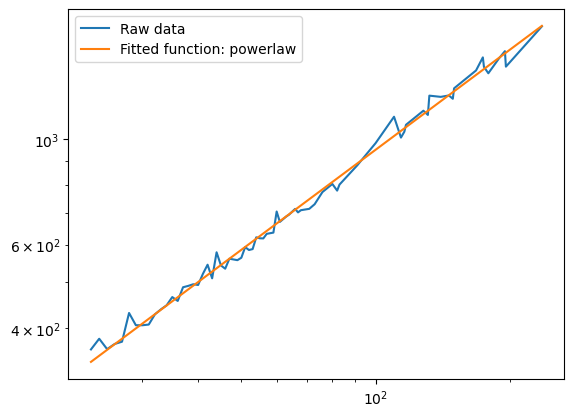

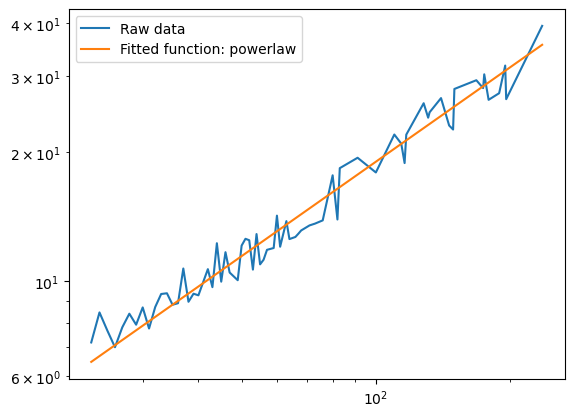

In [13]:
# Fit results
RN_fit_object.powerlaw.fit_results()
QN_fit_object.powerlaw.fit_results()
RN_fit_object.powerlaw.plot_fit()
QN_fit_object.powerlaw.plot_fit()

### 2.3. Perform renormalization

#### Before collapse

In [14]:
# OBSERVATION_WINDOWS = [x for x in OBSERVATION_WINDOWS if x in RN_df['x_values'].values]
rn = RN_df[RN_df['x_values'].isin(OBSERVATION_WINDOWS)]['y_values']
qn = QN_df[QN_df['x_values'].isin(OBSERVATION_WINDOWS)]['y_values']

IndexError: single positional indexer is out-of-bounds

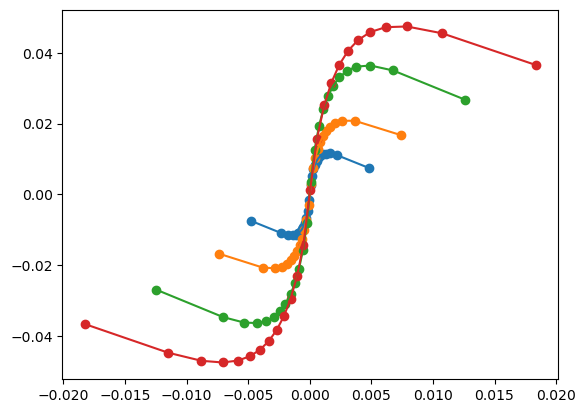

In [15]:
# Plot fitted scaling functions
for T in OBSERVATION_WINDOWS:
    data = smoothed_aggregate_impact[smoothed_aggregate_impact['T']==T][["vol_imbalance", "T", "R"]]
    data_binned = bin_data_into_quantiles(data, q=25)
    ys = data_binned["R"].values
    imbalance = data_binned["vol_imbalance"].values
    indx = OBSERVATION_WINDOWS.index(T)
    response = rescaled_form(imbalance, rn.iloc[indx], qn.iloc[indx], ALPHA, BETA)
    #plt.scatter(imbalance/qn.iloc[indx], ys/rn.iloc[indx]) # data
    plt.scatter(imbalance, response) # data
    # plt.scatter(imbalance, response) # fitted_values
    plt.plot(imbalance, response)

#### After Collapse

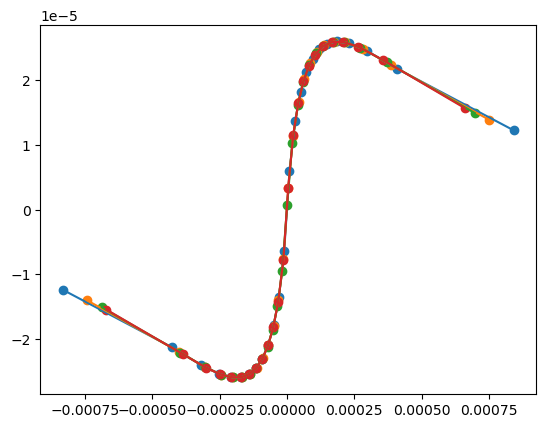

In [16]:
# Plot final rescaled functions
OBSERVATION_WINDOWS = [x for x in OBSERVATION_WINDOWS if x in RN_df['x_values'].values]

rn = RN_df[RN_df['x_values'].isin(OBSERVATION_WINDOWS)]['y_values']
qn = QN_df[QN_df['x_values'].isin(OBSERVATION_WINDOWS)]['y_values']

for T in OBSERVATION_WINDOWS:
    data = conditional_aggregate_impact[conditional_aggregate_impact['T']==T][["vol_imbalance", "T", "R"]]

    data["vol_imbalance"] = data["vol_imbalance"] / T**kappa
    data["R"] = data["R"] / T**chi

    data_binned = bin_data_into_quantiles(data, q=25)
    imbalance = data_binned["vol_imbalance"].values
    indx = OBSERVATION_WINDOWS.index(T)
    response = rescaled_form(imbalance, chi, kappa, ALPHA, BETA)
    plt.scatter(imbalance, response)
    plt.plot(imbalance, response)


In [16]:
# WE SHOULD BE USING RESCALED FORM MODEL PREDICTIONS FROM FIT AS Y_HAT VALUES, AND IN RENORMALIZATION

## TESTING

In [17]:
"""
- in TQP the collapse is of the scaling function (Figure 11.6 Scaling function)

- before collapse: fit scaling function to each features data at T
- after collapse: fit scaling funcion on each renormalised features data
"""

'\n- in TQP the collapse is of the scaling function (Figure 11.6 Scaling function)\n\n- before collapse: fit scaling function to each features data at T\n- after collapse: fit scaling funcion on each renormalised features data\n'

#### BEFORE COLLAPSE

In [18]:
display(smoothed_aggregate_impact)

,vol_imbalance,T,R
0,0.000004,1,0.000000
1,0.000054,1,0.236307
2,0.000288,1,0.236307
3,0.000288,1,0.000000
4,0.000144,1,2.363073
...,...,...,...
1407,0.024216,1000,68.152226
1408,-0.024216,1000,-166.121052
1409,-0.004140,1000,20.037084
1410,-0.006566,1000,-7.609019


In [19]:
OBSERVATION_WINDOWS = [10, 20, 50, 100, 150]

(-0.01, 0.01)

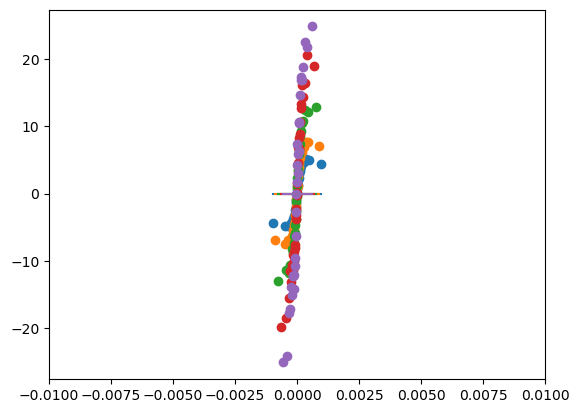

In [20]:
from liquidity.response_functions.functional_form import scaling_function

for T in OBSERVATION_WINDOWS:
    data = smoothed_aggregate_impact[smoothed_aggregate_impact['T']==T][["vol_imbalance", "T", "R"]]
    data_binned = bin_data_into_quantiles(data, q=31)
    ys = data_binned["R"].values
    imbalance = data_binned["vol_imbalance"].values / T**kappa
    indx = OBSERVATION_WINDOWS.index(T)
    response = scaling_function(imbalance, ALPHA, BETA)
    plt.scatter(imbalance, ys) # data
    plt.plot(imbalance, response) # fitted_values

plt.xlim((-0.01, 0.01))